In [1]:
import math 
import random 
import time 
import numpy as np
import cv2
import torch
import carla
from pathlib import Path
import sys

In [2]:
client = carla.Client('localhost', 2000) 
world = client.get_world()

In [ ]:


# ---------------- Initialization ----------------

settings = world.get_settings()
synchronous_mode = True
settings.synchronous_mode = synchronous_mode
settings.fixed_delta_seconds = 0.1 # This value might need adjustment
world.apply_settings(settings)

bp_lib = world.get_blueprint_library()
spawn_points = world.get_map().get_spawn_points()

# Spawn ego vehicle
vehicle_bp = bp_lib.find('vehicle.audi.a2')
vehicle = world.try_spawn_actor(vehicle_bp, random.choice(spawn_points))
vehicle.set_autopilot(True)

# Move spectator behind vehicle to view
spectator = world.get_spectator()
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-4,z=2.5)), vehicle.get_transform().rotation)
spectator.set_transform(transform)

camera_bp = bp_lib.find('sensor.camera.rgb')
camera_init_trans = carla.Transform(carla.Location(z=2))
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=vehicle)

model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/best.pt') # Assuming YOLOv5, adjust if YOLOv4
model.conf = 0.5

def process_image(image):
    array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
    array = np.reshape(array, (image.height, image.width, 4))
    array = array[:, :, :3]
    results = model(array)

    rendered_image = results.render()[0]
    
    cv2.imshow('Camera Feed', rendered_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()

camera.listen(lambda image: process_image(image))

# ---------------- Main Game Loop ----------------

try:
    while True:
        world.tick()
        # Add any other processing or rendering tasks you need
        #time.sleep(0.1) # Adjust as needed

except KeyboardInterrupt:
    pass
finally:
    camera.destroy()
    vehicle.destroy()
    if synchronous_mode:
        settings = world.get_settings()
        settings.synchronous_mode = False
        world.apply_settings(settings)


Using cache found in C:\Users\barry/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-10-18 Python-3.8.5 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 1765930 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


In [3]:
bp_lib = world.get_blueprint_library() 
spawn_points = world.get_map().get_spawn_points() 

# Spawn ego vehicle
vehicle_bp = bp_lib.find('vehicle.audi.a2') 
vehicle = world.try_spawn_actor(vehicle_bp, random.choice(spawn_points))

In [4]:
vehicle.set_autopilot(True)

In [5]:
# Move spectator behind vehicle to view
spectator = world.get_spectator() 
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-4,z=2.5)),vehicle.get_transform().rotation) 
spectator.set_transform(transform)

In [6]:
#Iterate this cell to find desired camera location
camera_bp = bp_lib.find('sensor.camera.rgb') 
camera_init_trans = carla.Transform(carla.Location(z=2)) #Change this to move camera
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=vehicle)

time.sleep(0.2)
spectator.set_transform(camera.get_transform())

In [7]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/best.pt')
model.conf = 0.5


Using cache found in C:\Users\barry/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-10-18 Python-3.8.5 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 1765930 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


In [ ]:
def process_image(image):
    # Convert the CARLA image to an array
    array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
    array = np.reshape(array, (image.height, image.width, 4))
    array = array[:, :, :3]

    # Use the YOLO model for detection
    results = model(array)
    results.render()  # Renders the predictions on the image

    # Display the image with detections
    cv2.imshow('Camera Feed', array)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
    time.sleep(1)

camera.listen(lambda image: process_image(image))

# Keep the script running
try:
    while True:
        pass
except KeyboardInterrupt:
    pass
finally:
    camera.destroy()
    vehicle.destroy()

WARNING  NMS time limit 0.550s exceeded
WARNING  NMS time limit 0.550s exceeded


________________________________________________________________________________________________________________________

________________________________________________________________________________________________________________________

In [11]:
# Callback stores sensor data in a dictionary for use outside callback                         
def camera_callback(image, data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))

# Get gamera dimensions and initialise dictionary                       
image_w = camera_bp.get_attribute("image_size_x").as_int()
image_h = camera_bp.get_attribute("image_size_y").as_int()
camera_data = {'image': np.zeros((image_h, image_w, 4))}

# Start camera recording
camera.listen(lambda image:camera_callback(image, camera_data))



In [ ]:
# # OpenCV named window for rendering
cv2.namedWindow('RGB Camera', cv2.WINDOW_AUTOSIZE)
cv2.imshow('RGB Camera', camera_data['image'])
cv2.waitKey(1)

# Game loop
while True:
    
    # Imshow renders sensor data to display
    cv2.imshow('RGB Camera', camera_data['image'])
    
    # Quit if user presses 'q'
    if cv2.waitKey(1) == ord('q'):
        break

# Close OpenCV window when finished
cv2.destroyAllWindows()

Using cache found in C:\Users\barry/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-10-18 Python-3.8.5 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 1765930 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


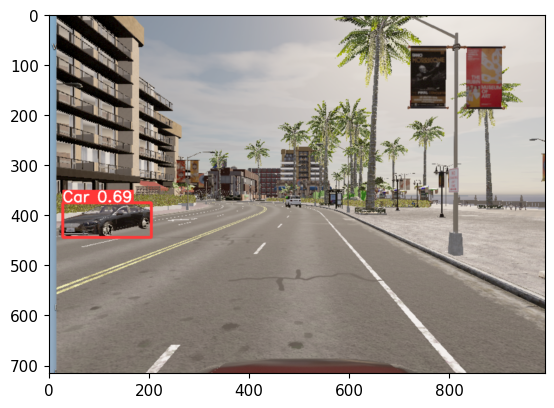

In [2]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image



# Function to load the YOLOv5 model
def load_yolov5_model(path):
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=path)
    model.conf = 0.5  # Set the confidence threshold
    return model

# Function to run inference and plot the results
def run_inference_and_plot(model, image_path):
    # Load image
    %matplotlib inline
    img = Image.open(image_path)

    # Run inference
    results = model(img)

    # Plot results
    results.render()
    image_with_boxes = Image.fromarray(results.render()[0])
    plt.imshow(image_with_boxes)
    plt.show()

# Specify the path to the model file and the image file
model_path = Path("E:/CARLA_0.9.13/WindowsNoEditor/PythonAPI/examples/yolov5/best.pt")
image_path = Path("C:/Users/barry/Downloads/t1.png")

# Load the YOLOv5 model
model = load_yolov5_model(model_path)

# Run inference and plot the results
run_inference_and_plot(model, image_path)


In [5]:
model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  

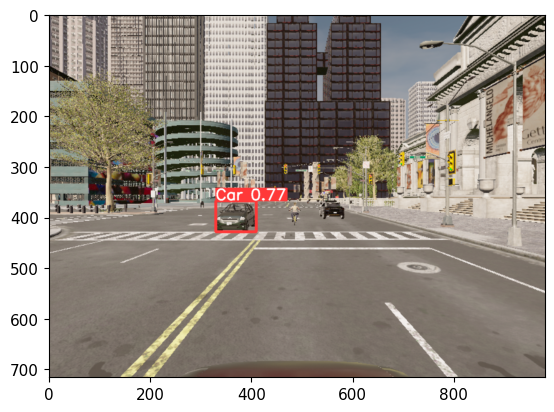

In [3]:
%matplotlib inline

image_path = Path("C:/Users/barry/Downloads/t2.png")
run_inference_and_plot(model, image_path)